# CHSolver User Tutorial

## Requirements
We assume the following software will be already available prior to installation:
- GCC/10.2.0
- CMake/3.20.1
- OpenMPI/4.0.5
- HDF5/1.10.7
- Python/3.8.6
- FFTW/3.3.8

## Installation
The repository can be git cloned via the command  $\texttt{ git clone --recursive git@github.com:HetSys/CHSolver.git}$

The code requires some external dependancies, which are linked to the repository through the use of git submodules. The bash script $\texttt{build\_deps}$ is provided in order to build and install these within the repository. It is recommended to run $\texttt{source build\_deps}$ in order for the Python virtual environment to correctly apply to the current shell.

If running the unit tests is desired, pFUnit should also be installed to the repository - the bash script \textt

Make is used as the main driver for the executable compilation and support. Supported commands are as follows:
- ```make```: Compile and link the chsolver executable
- ```make clean```: Clean the executables, .o and .mod files
- ```make logpurge```: Clean all .log files from the ./logs dir
- ```make docs```: Generate developer documentation (requires a doxygen executable on path, tested with Doxygen/1.8.17)
- ```make tests```: Compile and link a unit tests executable (requires pFUnit to have been installed within the repository)

## Handling JSON input data
JSON files are used by both the Python API and the $\texttt{chsolver}$ executable in order to parse input parameters to the executable. Though it is possible to use the the executable without a JSON file, it is strongly recommended (chsolver -h gives a list of supported flags which can be used alongside the JSON file).

The JSON datastructure operates via nesting of key/value pairs. At the root level, the JSON file is subdivided into "runs", where each run contains the full set of parameters required for proper execution of the program. A simple example file is shown below.

```
{
  "default": {
    "L": 1.0,
    "A": 1.0,
    "M": 0.25,
    "K": 0.0004,
    "p0": -1.0,
    "p1": 1.0,
    "grid_level": 7,
    "grid_type": "r",
    "T": [
      0.0,
      0.05,
      0.1
    ]
  }
}
```

The run, called "default" contains a nested set of parameters ("L", "A", "M", ...) which are searched by name during execution of the program. To add alternative runs directly to the file, it is recommended to first copy and paste the default run, rename it, and then modify the values associated with the parameters.

### Handling the JSON file from Python
The CHData class (from src/dataclass.py) provides an interface to generate and modify JSON files interactively.
A worked example of generating and adding a new run to a json file in the Python API is shown below. 

In [16]:
# PYTHON IMPORTS
import numpy as np
import os
import matplotlib.pyplot as plt
from src.dataclass import CHData
from src.visualisation import *

#plt.rcParams["animation.html"] = "jshtml"



In [17]:

# Generating an instance of CHData will create or open the file given by the fname init arg.
# If the file did not already exist, the default run will be saved to file
dat = CHData(fname="tutorial-data.json")

# Print the input data currently loaded
# By default, this will be the data contained in the "default" run in the
dat.print_rundata()

L = 1.0
A = 1.0
M = 0.25
K = 0.0004
p0 = -1.0
p1 = 1.0
Grid type = r
Grid level = 7
Output Times = [0.0, 0.05, 0.1]


In [18]:
# Modify the input data stored in the CHData object
dat.L = 2.0

dat.p0 = -3.0

dat.grid_level = 4

dat.T = np.linspace(0, 0.2, 5)

dat.grid_type = "c"

# Print out the modifications made to the input data
dat.print_rundata()

L = 2.0
A = 1.0
M = 0.25
K = 0.0004
p0 = -3.0
p1 = 1.0
Grid type = c
Grid level = 4
Output Times = [0.   0.05 0.1  0.15 0.2 ]


In [19]:
# Save the input data back down to the file
dat.save_rundata(run_name="modified")

Opening the "tutorial-data.json" file, it should now look like this:
```
{
  "default": {
    "L": 1.0,
    "A": 1.0,
    "M": 0.25,
    "K": 0.0004,
    "p0": -1.0,
    "p1": 1.0,
    "grid_level": 7,
    "grid_type": "r",
    "T": [
      0.0,
      0.05,
      0.1
    ]
  },
  "modified": {
    "L": 2.0,
    "A": 1.0,
    "M": 0.25,
    "K": 0.0004,
    "p0": -3.0,
    "p1": 1.0,
    "grid_level": 4,
    "grid_type": "c",
    "T": [
      0.0,
      0.05,
      0.1,
      0.15000000000000002,
      0.2
    ]
  }
}
```

Now we have a file containing multiple runs, we can look into quickly swapping between them.

In [20]:
# Create a new object, opening the same file
dat2 = CHData(fname="tutorial-data.json")

# Print the run names found in the file
print(dat2.run_names)

['default', 'modified']


In [21]:
# Print the currently loaded run data
dat2.print_rundata()

L = 1.0
A = 1.0
M = 0.25
K = 0.0004
p0 = -1.0
p1 = 1.0
Grid type = r
Grid level = 7
Output Times = [0.0, 0.05, 0.1]


In [22]:
# Read the data contained in the "modified" datastructure
dat2.read_rundata("modified")

# Verify the new data has been loaded
dat2.print_rundata()

L = 1.0
A = 1.0
M = 0.25
K = 0.0004
p0 = -1.0
p1 = 1.0
Grid type = r
Grid level = 7
Output Times = [0.0, 0.05, 0.1]


## Using the $\texttt{chsolver}$ executable

$\texttt{chsolver}$ can be built via the Makefile, using the command $\texttt{make}$. The executable comes with a fully featured command line interface in order to allow the program to perform a variety of tasks.

To demonstrate the program for this tutorial, we run shell commands via the python os.system() function.

In [23]:
# OPTIONAL: Compile the chsolver executable (if not already build)
os.system("make clean && make")

Message: No h5pfc (parallel wrapper) found, defaulting to h5fc (serial wrapper)
rm -f -r -d chsolver  ./obj/*.o ./src/*.mod ./out/** ./doxygen/output/* test_all
make -C tests/unit_tests clean
make[1]: Entering directory '/home/u2180064/Documents/GitHub/CHSolver/tests/unit_tests'
rm -f *.o *.mod *.a  *.inc *.F90
make[1]: Leaving directory '/home/u2180064/Documents/GitHub/CHSolver/tests/unit_tests'
Message: No h5pfc (parallel wrapper) found, defaulting to h5fc (serial wrapper)
mkdir -p ./obj ./out ./logs
Building obj/face.o
h5fc  -J./src -std=f2008 -c -o obj/face.o src/submodules/FACE/src/lib/face.F90
Building obj/logger_mod.o
h5fc  -J./src -std=f2008 -c -o obj/logger_mod.o src/submodules/flogging/src/logging.f90
Building obj/logging.o
h5fc  -J./src -O3 -Wall -Wextra -Wconversion-extra -std=f2008 -g -fall-intrinsics -fopenmp -I./src/submodules/bin/jsonfortran-gnu-8.2.5/lib -I/usr/include -c -o obj/logging.o src/logging.f90
Building obj/globals.o
h5fc  -J./src -O3 -Wall -Wextra -Wconversi

0

### Basic Usage

In [24]:
# Check the version of the program
version_command = "./chsolver --version"
os.system(version_command)

# Print help text

help_command = "./chsolver -h"
#os.system(help_command)


 CHSolver 1.0


--------------------------------------------------------------------------
MPI_ABORT was invoked on rank 0 in communicator MPI_COMM_WORLD
with errorcode 1.

NOTE: invoking MPI_ABORT causes Open MPI to kill all MPI processes.
You may or may not see output from other processes, depending on
exactly when Open MPI kills them.
--------------------------------------------------------------------------


In [25]:
# IO Commands

json_file = "tutorial-data.json"

output_dir = "tutorial-out"
os.makedirs(output_dir, exist_ok=True)

run_name = "modified"

exe = "./chsolver"

# -j <file> will change the json file searched for inputs
json_file_command = f" -j {json_file}"

# -o <dir> will change the location output files are saved to
output_dir_command = f" -o {output_dir}"

# -r <name> will change the name of the run parsed in the JSON for inputs 
run_name_command = f" -r {run_name}"


# Generate the full command
basic_command = exe + json_file_command + output_dir_command + run_name_command

print(basic_command)
os.system(basic_command)

./chsolver -j tutorial-data.json -o tutorial-out -r modified
[May 25 2022 17:04:38][open_json] <info> Reading tutorial-data.json
[May 25 2022 17:04:38][setup_grid] <info> Generating Random grid
[May 25 2022 17:04:38][solver_1] <info> Solving with fd2
[May 25 2022 17:04:38][solver_ufds2t2] <info> eps:   1.0000000000000000E-002                                                                                                      
[May 25 2022 17:04:38][solver_ufds2t2] <info> Initial output at t=  0.000     
[May 25 2022 17:04:38][solver_ufds2t2] <info> Output at t=  0.050             
[May 25 2022 17:04:39][solver_ufds2t2] <info> Output at t=  0.100             
[May 25 2022 17:04:39][main] <info> total time:   0.88052982999999996                                                                                                           


0

In [26]:
# Print the generated files
print(sorted(os.listdir(output_dir)))

['1.chkpnt', '2.chkpnt', '3.chkpnt', 'metadata.dat']


The executable first makes a "metadata.dat" file in the output directory, which contains the input parameters used for the run. It also contains a table linking the checkpoint number with the time the checkpointed data corresponds to.

The checkpoint files are binary files using the HDF5 storage scheme. They each contain the concentration grid C, as well as the grid state at the previous timestep, and the time interval used for that timestep (NOTE: timestep is not equivalent to the difference between output times, the solvers internally use an adaptive timestep scheme in order to provide stable and accurate outputs).

### Overriding the JSON inputs

In [27]:
# New values for parameters can be specified from the command line - if all of L, A, M, K, p0, p1, grid_init, grid_level and T 
# are defined from the command line, the json parsing is not done.

A_command = " -a 2.0"

p1_command = " -p1 0.01"

# Arrays in the command line have to be colon separated
T_command = " -t {0.0:0.1:0.2:0.3}"

full_command = basic_command + A_command + p1_command + T_command

print(full_command)
os.system(full_command)

./chsolver -j tutorial-data.json -o tutorial-out -r modified -a 2.0 -p1 0.01 -t {0.0:0.1:0.2:0.3}


At line 566 of file src/command-line.f90
Fortran runtime error: Bad real number in item 1 of list input

Error termination. Backtrace:
#0  0x7f1b78f7cd21 in ???
#1  0x7f1b78f7d869 in ???
#2  0x7f1b78f7e54f in ???
#3  0x7f1b791b9cf3 in ???
#4  0x7f1b791bb15c in ???
#5  0x7f1b791bbdc9 in ???
#6  0x5623f1ed3475 in __command_line_MOD_str_to_real
	at src/command-line.f90:566
#7  0x5623f1ed3475 in __command_line_MOD_parse_keyval_arg
	at src/command-line.f90:416
#8  0x5623f1ed406b in __command_line_MOD_parse_args
	at src/command-line.f90:324
#9  0x5623f1ed5136 in __command_line_MOD_initialise
	at src/command-line.f90:84
#10  0x5623f1eda5a2 in MAIN__
	at src/main.f90:62
#11  0x5623f1ec5dde in main
	at src/main.f90:2


512

### Advanced commands: Verbosity, easier time array specification

In [28]:
# Verbosity can be controlled via the -v (verbose) and -q (quiet) commands

#verbosity_command = " -qq"  # Very quiet (ignores warning messages)
verbosity_command = " -q" # Quiet (ignores info messages)
#verbosity_command = " " # No verbosity change
#verbosity_command = " -v" # Verbose (prints trivia messages)
#verbosity_command = " -vv" # Very verbose (prints debug messages)

#timespace_command = " --lin_tspace={0.0:0.2:5}" # Specify a linspace T from 0.0 to 0.2 with 5 outputs
timespace_command = " --log_tspace={0.0:0.2:5}" # Specify a logspace T from 0.0 to 0.2 with 5 outputs

full_command = basic_command + verbosity_command + timespace_command

print(full_command)
os.system(full_command)

./chsolver -j tutorial-data.json -o tutorial-out -r modified -q --log_tspace={0.0:0.2:5}


0

### Restarting from a checkpoint
The metadata and checkpoint files contain enough information for the simulation to be resumed from any of these points in the event of a fatal crash, or where the user desires to simulate the system further.

In the case of a checkpoint, the input time array is masked..... TODO

In [37]:
initial_command = basic_command + " --lin_tspace={0.0:0.1:5}"

os.system(initial_command)


#cont_from_time = "--restart_time=0.1" # Can specify a specific time to restart from. Will restart from a checkpoint with a time <= this time

cont_from_checkpoint = " --restart_num=-1" # Restart from a specific checkpoint number, with -1 meaning restart from the last checkpoint
continuation_times = " --lin_tspace{0.0:0.2:10}" # The times from 0.0 to 0.1 should be masked out of this array, as these have already been evaluated

restart_command = basic_command + cont_from_checkpoint + continuation_times

print(restart_command)
os.system(restart_command)

[May 25 2022 17:11:03][open_json] <info> Reading tutorial-data.json
[May 25 2022 17:11:03][setup_grid] <info> Generating Random grid
[May 25 2022 17:11:03][solver_1] <info> Solving with fd2
[May 25 2022 17:11:03][solver_ufds2t2] <info> eps:   1.0000000000000000E-002                                                                                                      
[May 25 2022 17:11:03][solver_ufds2t2] <info> Initial output at t=  0.000     
[May 25 2022 17:11:03][solver_ufds2t2] <info> Output at t=  0.025             
[May 25 2022 17:11:04][solver_ufds2t2] <info> Output at t=  0.050             
[May 25 2022 17:11:04][solver_ufds2t2] <info> Output at t=  0.075             
[May 25 2022 17:11:04][solver_ufds2t2] <info> Output at t=  0.100             
[May 25 2022 17:11:04][main] <info> total time:   0.91337149900000003                                                                                                           
./chsolver -j tutorial-data.json -o tutorial-out -r modifie

HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 140087524022208:
  #000: ../../../src/H5F.c line 509 in H5Fopen(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #001: ../../../src/H5Fint.c line 1400 in H5F__open(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: ../../../src/H5Fint.c line 1546 in H5F_open(): unable to open file: time = Wed May 25 17:11:05 2022
, name = '/0.chkpnt', tent_flags = 0
    major: File accessibilty
    minor: Unable to open file
  #003: ../../../src/H5FD.c line 734 in H5FD_open(): open failed
    major: Virtual File Layer
    minor: Unable to initialize object
  #004: ../../../src/H5FDsec2.c line 346 in H5FD_sec2_open(): unable to open file: name = '/0.chkpnt', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0
    major: File accessibilty
    minor: Unable to open file
HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 140087524022208:
  #000: ../../../sr

35584

### Python executable wrapper
For convenience, a simple interface to the executable is provided as a method of the CHData class. It internally calls the executable using the L, A, M, ... attributes and automatically reads the produced output files.

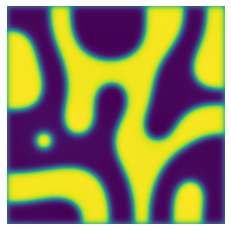

In [30]:
dat = CHData()

dat.grid_level = 6


# Can specify any additional command line args using a cmd_args string
dat.solve(out_dir="tutorial-out", cmd_args="-q")

# Plot last timestep
plt.imshow(dat.C[-1, :, :], interpolation="bicubic")
plt.axis("off")
plt.show()


# Output Files

The program produces several output files, placing them the given output directory. 

"metadata.dat" contains the top level metadata, such as the 6 parameters needed for the Cahn-Hilliard equation (L, A, M, K, p0, p1), as well as the grid level, and the output numbers and corresponding timesteps - output number "x" corresponds to the output contained in the "x.chkpnt" file.

The various "x.chkpnt" files created at runtime store the instantaneous concentration grid, C. The files also store the concentration grid for the previous internal timestep, as well as the time difference for the internal timestep; this information allows the code to restart a simulation from any of these output files.



## Working with output files from Python

The CHData class also provides functionality for working with the output files produced by the $\texttt{chsolver}$ program.

In [31]:
dat2 = CHData(fname="tutorial-data.json")

# Read output data into the CHData object
dat2.read_outputs("tutorial-out")

# Visualisation

The user can generate an animation of the concentration with time as an mp4 or GIF file, and a plot of the free energy versus time (png) by calling python3 src/visualisation.py. These will be saved to the main directory.
Should the user wish to change the animation's fps (default 10) or specify the time interval for either of the (default start to finish), for either of the visuals, then the python file can be opened and the arguments to the $\texttt{plot\_conc\_evol}$ and $\texttt{plot\_free\_energy}$ functions at the bottom of the file can be changed.

In [32]:
# Generate a dataset
dat = CHData()
dat.T = np.linspace(0, 20, 30)
dat.solve(out_dir="tutorial-out", cmd_args="--solver=fd")

# Data loaded automatically but can also manually
# fetch it
dat.read_outputs("tutorial-out")

[May 25 2022 17:04:46][open_json] <info> Reading input-data.json
[May 25 2022 17:04:46][setup_grid] <info> Generating Random grid
[May 25 2022 17:04:46][solver_1] <info> Solving with fd2
[May 25 2022 17:04:46][solver_ufds2t2] <info> eps:   1.0000000000000000E-002                                                                                                      
[May 25 2022 17:04:46][solver_ufds2t2] <info> Initial output at t=  0.000     
[May 25 2022 17:04:48][solver_ufds2t2] <info> Output at t=  0.690             
[May 25 2022 17:04:48][solver_ufds2t2] <info> Output at t=  1.379             
[May 25 2022 17:04:48][solver_ufds2t2] <info> Output at t=  2.069             
[May 25 2022 17:04:48][solver_ufds2t2] <info> Output at t=  2.759             
[May 25 2022 17:04:48][solver_ufds2t2] <info> Output at t=  3.448             
[May 25 2022 17:04:49][solver_ufds2t2] <info> Output at t=  4.138             
[May 25 2022 17:04:49][solver_ufds2t2] <info> Output at t=  4.828             
[M

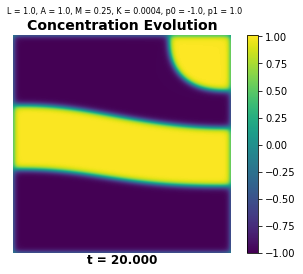

In [33]:
# Plot the system evolution as an animation
# Returns a matplotlib ArtistAnimation object
ani = plot_conc_evol(dat)
ani


Should a specific snapshot in time be required, the user can use $\texttt{plot\_conc\_snapshot}$ with their desired time - the closest time prior (or equal) to that specified will be used.

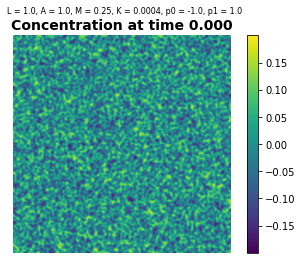

In [34]:
# Plot the concentration map at a user specificed time:
# Returns a matplotlib ArtistAnimation object
ani = plot_conc_snapshot(dat, t = 0.0)
plt.show()

All the visualisation functions have a metadata flag (set to True by default), which displays the parameters used by the solver to generate the output. The run_visualisation script can be used to quickly output the concentration evolution and free energy visuals (with default arguments) to the main directory, should the user not wish to enter a python file/environment.